<a href="https://colab.research.google.com/github/andzagz/sc-healthcare-trends/blob/main/beneficiarios_lightgmb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Carregar os dados
file_path = "/content/drive/MyDrive/Colab Notebooks/Case beneficiarios/dados_beneficiarios_clean.csv"
df = pd.read_csv(file_path, delimiter=',', engine='python', encoding='latin-1')

# Verificar o nome correto da coluna
print(df.head)

<bound method NDFrame.head of                              Data  Beneficiarios
0   2016-03-31 23:59:59.999999999        1466988
1   2016-06-30 23:59:59.999999999        1485164
2   2016-09-30 23:59:59.999999999        1486209
3   2016-12-31 23:59:59.999999999        1488573
4   2017-03-31 23:59:59.999999999        1484912
5   2017-06-30 23:59:59.999999999        1488172
6   2017-09-30 23:59:59.999999999        1493664
7   2017-12-31 23:59:59.999999999        1504839
8   2018-03-31 23:59:59.999999999        1492904
9   2018-06-30 23:59:59.999999999        1501111
10  2018-09-30 23:59:59.999999999        1506029
11  2018-12-31 23:59:59.999999999        1505341
12  2019-03-31 23:59:59.999999999        1477748
13  2019-06-30 23:59:59.999999999        1503821
14  2019-09-30 23:59:59.999999999        1485755
15  2019-12-31 23:59:59.999999999        1471797
16  2020-03-31 23:59:59.999999999        1469759
17  2020-06-30 23:59:59.999999999        1457262
18  2020-09-30 23:59:59.999999999      

In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Supondo que df é o seu DataFrame e já está carregado
df['Data'] = pd.to_datetime(df['Data'])  # Garantir que a coluna Data está no formato datetime

# Filtrar dados a partir de 2016
df = df[df['Data'] >= '2021-01-01']
print(df.head())

df = df.sort_values('Data')  # Ordenar os dados pela data

# Criar lags (features de atraso)
def create_lags(df, lags):
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df['Beneficiarios'].shift(lag)
    return df

# Cria 3 lags como exemplo
df_lag = create_lags(df, lags=3)

# Remover valores NaN gerados pelos lags
df_lag = df_lag.dropna()

# Separar as variáveis de entrada (X) e a variável target (y)
X = df_lag.drop(columns=['Data', 'Beneficiarios'])
y = df_lag['Beneficiarios']

# Dividir em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


                            Data  Beneficiarios
20 2021-03-31 23:59:59.999999999        1497018
21 2021-06-30 23:59:59.999999999        1515111
22 2021-09-30 23:59:59.999999999        1552687
23 2021-12-31 23:59:59.999999999        1576558
24 2022-03-31 23:59:59.999999999        1584914


In [ ]:
# Inicializar o modelo XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)

# Treinar o modelo
model.fit(X_train, y_train)

# Fazer previsões
y_pred = model.predict(X_test)

# Avaliar o modelo
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')


RMSE: 12896.019184511617


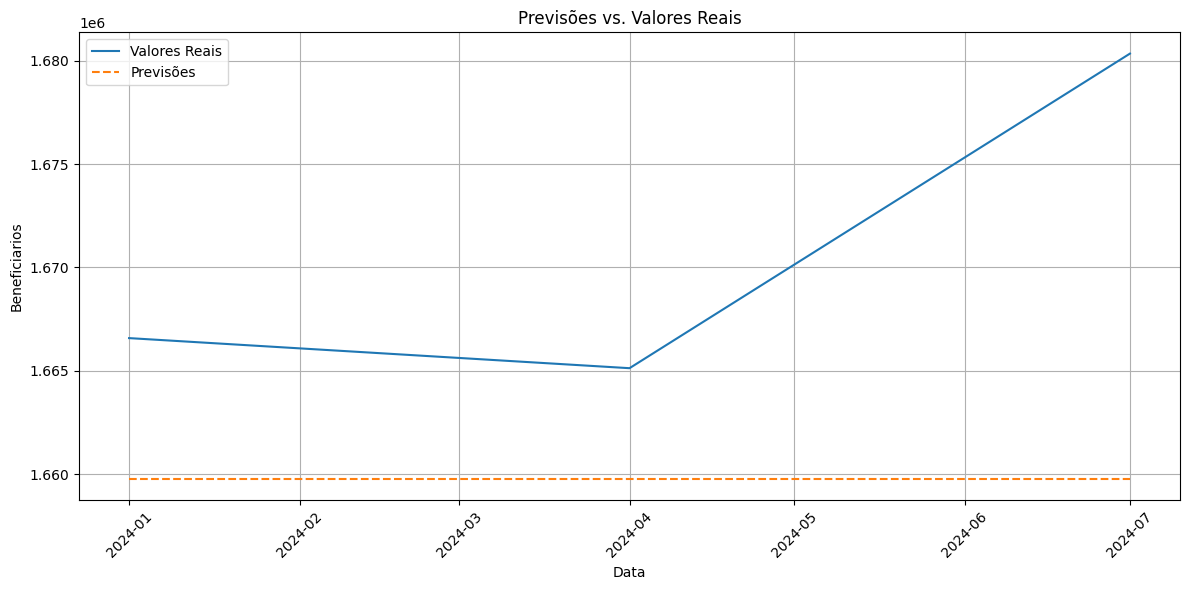

In [ ]:
import matplotlib.pyplot as plt

# Alinhar previsões com as datas de teste
dates_test = df_lag['Data'].iloc[-len(y_test):]

# Plotar as previsões e os valores reais
plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_test.values, label='Valores Reais')
plt.plot(dates_test, y_pred, label='Previsões', linestyle='--')
plt.xlabel('Data')
plt.ylabel('Beneficiarios')
plt.title('Previsões vs. Valores Reais')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
!pip install optuna xgboost


In [ ]:
import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

def objective(trial):
    # Definir os hiperparâmetros a serem otimizados
    params = {
        'objective': 'reg:squarederror',
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e-1)
    }

    # Inicializar o modelo XGBoost com os parâmetros sugeridos
    model = xgb.XGBRegressor(**params)

    # Treinar o modelo
    model.fit(X_train, y_train)

    # Fazer previsões
    y_pred = model.predict(X_test)

    # Calcular as métricas
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Retornar o valor da métrica principal para otimização (por exemplo, RMSE)
    return rmse  # Você pode retornar qualquer métrica para otimização


In [ ]:
# Criar um estudo Optuna
study = optuna.create_study(direction='minimize')  # Minimizar a métrica de avaliação (RMSE)

# Executar a otimização
study.optimize(objective, n_trials=50)  # Número de experimentos (trials)

# Resultados da otimização
print("Melhores parâmetros:", study.best_params)
print("Melhor valor de RMSE:", study.best_value)


[I 2024-09-12 16:20:36,611] A new study created in memory with name: no-name-c5a0adf5-ce89-449e-9624-e6197ca85022
<ipython-input-25-42ec5740d369>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
<ipython-input-25-42ec5740d369>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-25-42ec5740d369>:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 

Melhores parâmetros: {'n_estimators': 194, 'max_depth': 5, 'learning_rate': 0.06418572354495149, 'subsample': 0.9708517657931178, 'colsample_bytree': 0.7622846546104269, 'gamma': 0.0021159406403228535}
Melhor valor de RMSE: 14005.131325064098


In [ ]:
#Melhores parâmetros: {'n_estimators': 191, 'max_depth': 10, 'learning_rate': 0.09932790359768841, 'subsample': 0.8832132171408393, 'colsample_bytree': 0.5736839517069541, 'gamma': 0.004339230760131214}
#Melhor valor de RMSE: 36037.92841301147

# Treinar o modelo final com os melhores parâmetros encontrados
best_params = study.best_params
best_model = xgb.XGBRegressor(**best_params)
best_model.fit(X_train, y_train)

# Fazer previsões e avaliar o modelo final
y_final_pred = best_model.predict(X_test)

# Calcular as métricas
final_rmse = np.sqrt(mean_squared_error(y_test, y_final_pred))
final_mae = mean_absolute_error(y_test, y_final_pred)
final_mape = mean_absolute_percentage_error(y_test, y_final_pred)
final_r2 = r2_score(y_test, y_final_pred)

print(f'RMSE do modelo final: {final_rmse}')
print(f'MAE do modelo final: {final_mae}')
print(f'MAPE do modelo final: {final_mape}')
print(f'R² do modelo final: {final_r2}')


RMSE do modelo final: 14005.131325064098
MAE do modelo final: 12524.375
MAPE do modelo final: 0.007482041766681602
R² do modelo final: -3.167143638909516


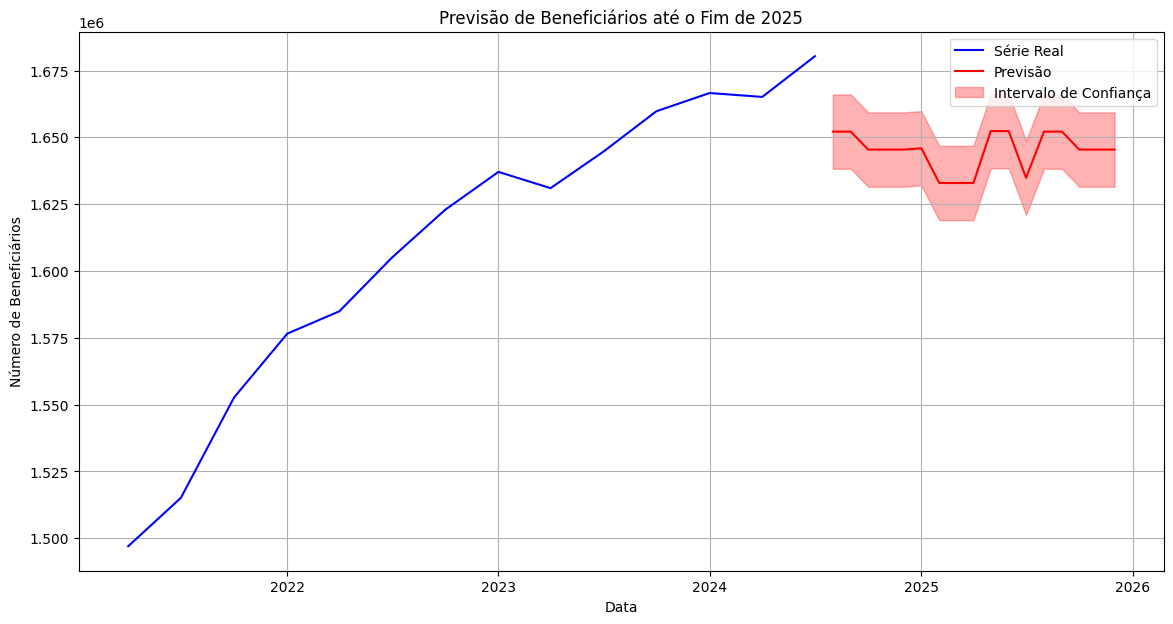

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Supondo que df seja o seu DataFrame original
# Convertendo a coluna 'Data' para um formato numérico
df['Data'] = pd.to_datetime(df['Data'])
df['Year'] = df['Data'].dt.year
df['Month'] = df['Data'].dt.month
df['Day'] = df['Data'].dt.dayofyear  # Dia do ano

# Definindo as características e o alvo
X = df[['Year', 'Month', 'Day']]
y = df['Beneficiarios']

# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinando o modelo XGBoost
best_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,
    max_depth=10,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1
)

best_model.fit(X_train, y_train)

# Preparar dados para previsões futuras
# Iniciar a partir do último ponto de dados real
last_date = df['Data'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), end='2025-12-31', freq='M')

# Criar DataFrame para as datas futuras
future_df = pd.DataFrame({'Date': future_dates})
future_df['Year'] = future_df['Date'].dt.year
future_df['Month'] = future_df['Date'].dt.month
future_df['Day'] = future_df['Date'].dt.dayofyear

# Preparar características para o futuro
future_X = future_df[['Year', 'Month', 'Day']]
future_predictions = best_model.predict(future_X)

# Adicionar previsões ao DataFrame futuro
future_df['Prediction'] = future_predictions

# Adicionar previsões ao DataFrame original para visualização
df_combined = pd.concat([df, future_df], ignore_index=True)

# Plotar a série real e a previsão
plt.figure(figsize=(14, 7))
plt.plot(df['Data'], df['Beneficiarios'], label='Série Real', color='blue')
plt.plot(future_df['Date'], future_df['Prediction'], label='Previsão', color='red')

# Intervalo de Confiança (Estimado)
confidence_interval = 1.96 * np.std(future_predictions)  # Exemplo de intervalo de confiança
plt.fill_between(future_df['Date'],
                 future_predictions - confidence_interval,
                 future_predictions + confidence_interval,
                 color='red', alpha=0.3, label='Intervalo de Confiança')

plt.xlabel('Data')
plt.ylabel('Número de Beneficiários')
plt.title('Previsão de Beneficiários até o Fim de 2025')
plt.legend()
plt.grid(True)
plt.show()
